In [30]:
import pandas as pd
import os
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
import featurization as fzn
import joblib

base_url = 'D:/GITHUB/ML_SSE'
# The directory contains the dataset that has been divided into train, val, and test data with a 5 fold cross validation scheme
data_url = os.path.join(base_url, 'data/preprocessed_dataset/5fold_cv')

## Model Evaluation

In [24]:
def reader_dataset(url):
    list_folder = listdir(url)
    list_df = []
    for f in list_folder:
        df_train = pd.read_csv(url+'/'+f+'/train.csv')
        df_val = pd.read_csv(url+'/'+f+'/val.csv')
        df_test = pd.read_csv(url+'/'+f+'/test.csv')
        list_df.append([df_train, df_test])
    return list_df

def confusion_matrix_calc(actual_, predict_, boundary):
    assert len(actual_)==len(predict_)
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for n in range(len(actual_)):
        if actual_[n]>=boundary and predict_[n]>=boundary:
            TP+=1
        elif actual_[n]<boundary and predict_[n]<boundary:
            TN+=1
        elif actual_[n]>=boundary and predict_[n]<boundary:
            FN+=1
        elif actual_[n]<boundary and predict_[n]>=boundary:
            FP+=1
    return TP, TN, FP, FN

def model_test(train, test, model):
    X_train, y_train, formulae_train = fzn.apply_scheme(train['formula'], list(train['target']))
    X_test, y_test, formulae_test = fzn.apply_scheme(test['formula'], list(test['target']))
    
    scalar = MinMaxScaler()
    X_train_scaled = scalar.fit_transform(X_train)
    X_test_scaled = scalar.transform(X_test)
    print
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return y_test, y_pred, formulae_test

In [26]:
mae_list = []
pred_list = []
y_list = []
formula_list = []
recall_list = []
precision_list = []
f1_list = []
rmse_list = []
r2_list = []

data_kfold = reader_dataset(data_url) #read data

for d in range(len(data_kfold)):
    train = data_kfold[d][0]
    test = data_kfold[d][1]
    
    model = RandomForestRegressor(random_state = 1, n_estimators= 300, min_samples_split= 5, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 50, bootstrap= False)
    
    y_test, y_pred, formulae_test = model_test(train, test, model)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    mae_list.append(mae)
    r2_list.append(r2)
    rmse_list.append(rmse)
    pred_list.append(list(y_pred))
    y_list.append(list(y_test))
    formula_list.append(list(formulae_test))

    TP, TN, FP, FN = confusion_matrix_calc(y_test, y_pred, -4)
    print('TP={}, TN={}, FP={}, FN={}'.format(TP, TN, FP, FN))
    rec_ = TP/(TP+FN)
    pre_ = TP/(TP+FP)
    f1_score = 2 * (pre_ * rec_) / (pre_ + rec_)
    recall_list.append(rec_)
    precision_list.append(pre_)
    f1_list.append(f1_score)
    
    print('Fold {} - MAE: {} - F1: {}'.format(d+1, mae, f1_score))
    
print('Avg MAE: {} - Avg Recall: {} - Avg Precision: {} - Avg F1: {}'.format(sum(mae_list)/len(mae_list), sum(recall_list)/len(recall_list), sum(precision_list)/len(precision_list), sum(f1_list)/len(f1_list)))
print('Avg R2: {} - Avg RMSE: {}'.format(sum(r2_list)/len(r2_list), sum(rmse_list)/len(rmse_list)))

(690, 161)
(216, 161)


C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


TP=101, TN=95, FP=8, FN=12
Fold 1 - MAE: 0.6213289537540261 - F1: 0.9099099099099099
(690, 161)
(216, 161)


C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


TP=94, TN=95, FP=8, FN=19
Fold 2 - MAE: 0.6874568632332125 - F1: 0.8744186046511628
(690, 161)
(216, 161)


C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


TP=95, TN=95, FP=8, FN=18
Fold 3 - MAE: 0.6373750413930179 - F1: 0.8796296296296297
(691, 161)
(216, 161)


C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


TP=96, TN=93, FP=10, FN=17
Fold 4 - MAE: 0.6075133808790175 - F1: 0.8767123287671234
(691, 161)
(216, 161)


C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


TP=98, TN=96, FP=7, FN=15
Fold 5 - MAE: 0.621850384960995 - F1: 0.8990825688073395
Avg MAE: 0.6351049248440538 - Avg Recall: 0.856637168141593 - Avg Precision: 0.9218995879634677 - Avg F1: 0.8879506083530331
Avg R2: 0.6632704303130549 - Avg RMSE: 1.16615849354198


## Training


In [49]:
train1 = pd.read_csv(data_url+'/1/train.csv')
val1 = pd.read_csv(data_url+'/1/val.csv')
test1 = pd.read_csv(data_url+'/1/test.csv')
all_data = pd.concat([train1, val1, test1]).reset_index()

X_data, y_data, _ = fzn.apply_scheme(all_data['formula'], list(all_data['target']))
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_data)
    
model = RandomForestRegressor(random_state = 1, n_estimators= 300, min_samples_split= 5, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 50, bootstrap= False)
model.fit(X_train_scaled, y_data)

data_to_save = [model, scaler]
model_url = os.path.join(base_url, 'model.joblib')
joblib.dump(data_to_save, model_url)

(1079, 161)


C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


['D:/GITHUB/ML_SSE\\model.joblib']

## Predict new data

In [50]:
new_data = pd.read_csv(os.path.join(base_url, 'element_substitution/new_formula.csv'))
dummy_target = [0]*len(new_data)

In [51]:
X_new_data, y_new_data, formulae_new_data = fzn.apply_scheme(new_data['new_formula'], dummy_target)

(18262, 161)


In [52]:
model, scaler = joblib.load(model_url)

X_new_data = scaler.transform(X_new_data)

prediction = model.predict(X_new_data)
df_predict = pd.DataFrame({'formula': new_data['new_formula'], 'prediction':prediction})
df_predict

C:\Users\A1\miniconda3\envs\p0\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


,formula,prediction
0,Li4.2Si0.8Ga0.2S4,-6.889458
1,Li4.2Si0.8Fe0.2S4,-6.577390
2,Li4.2Si0.8Cr0.2S4,-6.517595
3,Li4.2Si0.8In0.2S4,-6.264806
4,Li4.2Si0.8Co0.2S4,-6.521149
...,...,...
18257,Li7Ho3Sn2O12,-6.548599
18258,Li7Ho3Tb2O12,-7.818716
18259,Li7Ho3Mo2O12,-7.085422
18260,Li7Ho3Pb2O12,-6.200899


<AxesSubplot:>

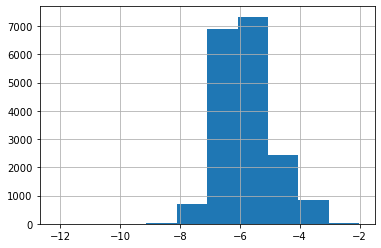

In [53]:
df_predict['prediction'].hist()

In [54]:
df_predict.to_csv(os.path.join(base_url, 'new_formula_prediction.csv'))